<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/Model_Nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uplift and Profit prediction


*  **Uplift**
  * Model:  CausalML_uplift_1.pkl, CausalML_uplift_2.pkl, CausalML_uplift_3.pkl
  * Data: data202308.csv

* **X-Learner**
  * Model:  EconML_X_202306.pkl
  * Data: data202308.csv

*   **Profit**
  * Model:  EEconml_RF_202306.pkl, Econml_CF_202306.pkl
  * Data: data202308.csv



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202311.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [11]:
import pandas as pd
import numpy as np

# Load your May data
oct_data = pd.read_csv('/content/data202311.csv', index_col=0)
#aug_data = subsets[0]
unino = oct_data['UNINO']
oct_data.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO'], axis = 'columns', inplace = True)

#201 columns
oct_data.columns

Index(['年齡', '公司戶記號', '性別', '呆帳記號_含信用卡', '客戶年收入', '網路會員記號', '網路使用記號_行動銀行',
       '小mma記號', '網路服務記號', '網路使用記號',
       ...
       '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1',
       '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y'],
      dtype='object', length=201)

## CausalML

In [ ]:
!pip install causalml
!pip install duecredit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.4/909.4 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 38.8 MB/s eta 0:00:00
  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Using cached Cython-0.29.34-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/

In [ ]:
import numpy as np
import pandas as pd
import duecredit

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, get_cumgain
from sklearn.model_selection import train_test_split

import importlib
print(importlib.metadata.version('causalml') )

0.14.1


In [12]:
import pickle
def load_model(model_path):
   """Load a pickled model."""
   return pickle.load(open(model_path, "rb"))

def get_results(model_index, df, data, model_prefix="CasualML_uplift_202306_"):
   """Run model predictions and update DataFrame."""
   model_path = f"/content/drive/MyDrive/Model/{model_prefix}{model_index}.pkl"
   model = load_model(model_path)
   df_res = model.predict(data, full_output=True)
   df[f'Uplift_{model_index}|T=0'] = df_res.iloc[:, 0]
   df[f'Uplift_{model_index}|T=1'] = df_res.iloc[:, 1]
   print(f'Finish running uplift_new_{model_index}')
   return df

def calculate_mean_uplifts(res, model_count=5):
   """Calculate mean uplifts and return a DataFrame."""
   T = [f'Uplift_{i}|T=0' for i in range(1, model_count + 1)]
   T1 = [f'Uplift_{i}|T=1' for i in range(1, model_count + 1)]
   res_columns = res[T + T1]
   pred = pd.DataFrame()
   pred['Uplift_mean|T=0'] = res_columns[T].mean(axis=1)
   pred['Uplift_mean|T=1'] = res_columns[T1].mean(axis=1)
   pred['Uplift_mean'] = pred['Uplift_mean|T=1'] - pred['Uplift_mean|T=0']
   return pred

# Example usage
res_df = pd.DataFrame()
for i in range(1, 6):
   res_df = get_results(i, res_df, oct_data)
pred = calculate_mean_uplifts(res_df)
pred

ModuleNotFoundError: ignored

##X-Learner

In [13]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 22.9 MB/s eta 0:00:00


In [14]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [ ]:
import pickle
def get_other_results(model_list, name_list, df, data):
  for i in range(len(model_list)):
    with open ("/content/drive/MyDrive/Model/"+ model_list[i], "rb") as file:
      est = pickle.load(file)
    if i ==2:
      df[name_list[i]] = est.predict(data)
    else :
      df[name_list[i]] = est.effect(data)
  return df

##使用
model_list = ['EconML_X_202306_new_1.pkl', 'Value_EconML_X_202306.pkl', 'Econml_RF_202306_new.pkl', 'Econml_CF_202306_new.pkl']
name_list = ['X_te_2', 'Value_X', 'E(V)|T = 0, D = 1', 'te']
pred = get_other_results(model_list, name_list, pred, oct_data)
pred['E(V)|T = 1, D = 1'] = pred['E(V)|T = 0, D = 1'] + pred['te']
pred

In [ ]:
!pip install

In [ ]:
pred.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202308_new.csv')
#1054433 rows × 9 columns

In [ ]:
import pandas as pd
pred = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202308_new.csv', index_col = 0)
pred

,UNINO,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,A1521309050,0.0059,0.001373,0.048074,0.046701,0.004857,88067.946333,-18086.505294,69981.441039
1,A1521310270,43.1608,0.003127,0.043591,0.040463,0.005268,68208.224027,-16562.628867,51645.595160
2,A1521312590,2.4923,0.001788,0.050031,0.048243,0.004894,91168.411721,-17048.049118,74120.362603
3,A1521318940,66.0665,0.002848,0.056080,0.053232,0.006392,103617.724284,-17359.005021,86258.719263
4,A1521321420,15.3138,0.001631,0.062387,0.060756,0.001691,118600.440766,-19618.657805,98981.782961
...,...,...,...,...,...,...,...,...,...
1054428,Y2729821390,0.0000,0.003953,0.037444,0.033491,0.006932,111131.614951,-18184.741163,92946.873788
1054429,Y2729821750,86.4484,0.004097,0.034036,0.029939,0.004487,111857.440722,-27972.861372,83884.579350
1054430,Y2729823350,25.8643,0.001663,0.055808,0.054145,0.004845,135709.481509,-19017.106024,116692.375485
1054431,Y2729824530,0.0000,0.005949,0.037284,0.031335,0.002764,41756.854031,-16981.356344,24775.497687


In [ ]:
pred.describe()

,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
count,1.054433e+06,1.054433e+06,1.054433e+06,1.054433e+06,1.054433e+06,1.054433e+06,1.054433e+06,1.054433e+06
mean,4.764068e+01,2.880118e-03,4.425563e-02,4.137551e-02,7.287296e-03,1.112805e+05,-1.757006e+04,9.371040e+04
std,3.019562e+01,1.463678e-03,8.487338e-03,9.545917e-03,1.875801e-02,2.950705e+04,6.649850e+03,2.952517e+04
min,0.000000e+00,7.996501e-04,1.596074e-02,-9.112811e-03,-4.422002e-01,2.445476e+04,-1.048962e+05,6.545673e+03
25%,2.121890e+01,1.708004e-03,3.766452e-02,3.398898e-02,3.369724e-03,9.399464e+04,-1.839117e+04,7.688579e+04
50%,4.766060e+01,2.761591e-03,4.140432e-02,3.879149e-02,4.394518e-03,1.093627e+05,-1.736858e+04,9.210743e+04
75%,7.383320e+01,3.814756e-03,5.210633e-02,4.992623e-02,4.901757e-03,1.238658e+05,-1.642940e+04,1.062325e+05
max,1.000000e+02,3.249452e-02,7.386486e-02,7.263583e-02,8.537941e-01,4.757274e+05,2.450816e+05,6.482646e+05


In [ ]:
res = pd.DataFrame()
res = pred.iloc[:,:8]
res['X_te'] = pred['X_te'].values
res['X_te_2'] = pred['X_te_2']
res['E(V)|X,T = 0'] = pred['Uplift_mean|T = 0'] * pred['E(V)|T = 0, D = 1']
res['E(V)|X,T = 1'] = pred['Uplift_mean|T = 1'] * pred['E(V)|T = 1, D = 1']
res['Gi'] = res['E(V)|X,T = 1']-res['E(V)|X,T = 0']
res['Value_X'] = pred['Value_X']
#res['Value_mean'] = pred['Value_mean']
res

,UNINO,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,X_te_2,"E(V)|X,T = 0","E(V)|X,T = 1",Gi,Value_X
0,A1521309050,0.0059,0.001373,0.048074,0.046701,0.004857,88067.946333,-18086.505294,0.011754,120.900778,3364.284911,3243.384134,223.705913
1,A1521310270,43.1608,0.003127,0.043591,0.040463,0.005268,68208.224027,-16562.628867,0.012860,213.316467,2251.258464,2037.941997,225.402402
2,A1521312590,2.4923,0.001788,0.050031,0.048243,0.004894,91168.411721,-17048.049118,0.011814,162.978677,3708.299031,3545.320354,224.873296
3,A1521318940,66.0665,0.002848,0.056080,0.053232,0.006392,103617.724284,-17359.005021,0.016154,295.100096,4837.414952,4542.314857,491.291660
4,A1521321420,15.3138,0.001631,0.062387,0.060756,0.001691,118600.440766,-19618.657805,0.014543,193.417067,6175.182307,5981.765239,223.320797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054428,Y2729821390,0.0000,0.003953,0.037444,0.033491,0.006932,111131.614951,-18184.741163,0.007109,439.356425,3480.311736,3040.955312,488.858419
1054429,Y2729821750,86.4484,0.004097,0.034036,0.029939,0.004487,111857.440722,-27972.861372,0.009792,458.271388,2855.056602,2396.785214,460.483859
1054430,Y2729823350,25.8643,0.001663,0.055808,0.054145,0.004845,135709.481509,-19017.106024,0.011421,225.692785,6512.316657,6286.623872,55.533310
1054431,Y2729824530,0.0000,0.005949,0.037284,0.031335,0.002764,41756.854031,-16981.356344,-0.000560,248.414134,923.727788,675.313654,343.290662


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202308_new.csv')
#1054433 rows × 9 columns

In [ ]:
res.iloc[:,-2:].describe()

,Gi,Value_X
count,1.054433e+06,1.054433e+06
mean,3.811340e+03,4.333570e+02
std,1.367574e+03,9.589253e+03
min,-2.987235e+03,-6.279616e+05
25%,2.800454e+03,2.234966e+02
50%,3.797286e+03,2.249963e+02
75%,4.727086e+03,3.215383e+02
max,2.312124e+04,2.887331e+06


In [ ]:
import pandas as pd
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202308_new.csv', index_col = 0)
res

,UNINO,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,X_te_2,"E(V)|X,T = 0","E(V)|X,T = 1",Gi,Value_X
0,A1521309050,0.0059,0.001373,0.048074,0.046701,0.004857,88067.946333,-18086.505294,0.011754,120.900778,3364.284911,3243.384134,223.705913
1,A1521310270,43.1608,0.003127,0.043591,0.040463,0.005268,68208.224027,-16562.628867,0.012860,213.316467,2251.258464,2037.941997,225.402402
2,A1521312590,2.4923,0.001788,0.050031,0.048243,0.004894,91168.411721,-17048.049118,0.011814,162.978677,3708.299031,3545.320354,224.873296
3,A1521318940,66.0665,0.002848,0.056080,0.053232,0.006392,103617.724284,-17359.005021,0.016154,295.100096,4837.414952,4542.314857,491.291660
4,A1521321420,15.3138,0.001631,0.062387,0.060756,0.001691,118600.440766,-19618.657805,0.014543,193.417067,6175.182307,5981.765239,223.320797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054428,Y2729821390,0.0000,0.003953,0.037444,0.033491,0.006932,111131.614951,-18184.741163,0.007109,439.356425,3480.311736,3040.955312,488.858419
1054429,Y2729821750,86.4484,0.004097,0.034036,0.029939,0.004487,111857.440722,-27972.861372,0.009792,458.271388,2855.056602,2396.785214,460.483859
1054430,Y2729823350,25.8643,0.001663,0.055808,0.054145,0.004845,135709.481509,-19017.106024,0.011421,225.692785,6512.316657,6286.623872,55.533310
1054431,Y2729824530,0.0000,0.005949,0.037284,0.031335,0.002764,41756.854031,-16981.356344,-0.000560,248.414134,923.727788,675.313654,343.290662


In [ ]:
res['Gi'].corr(res['Value_X'])

0.0156889928593765

##Plot

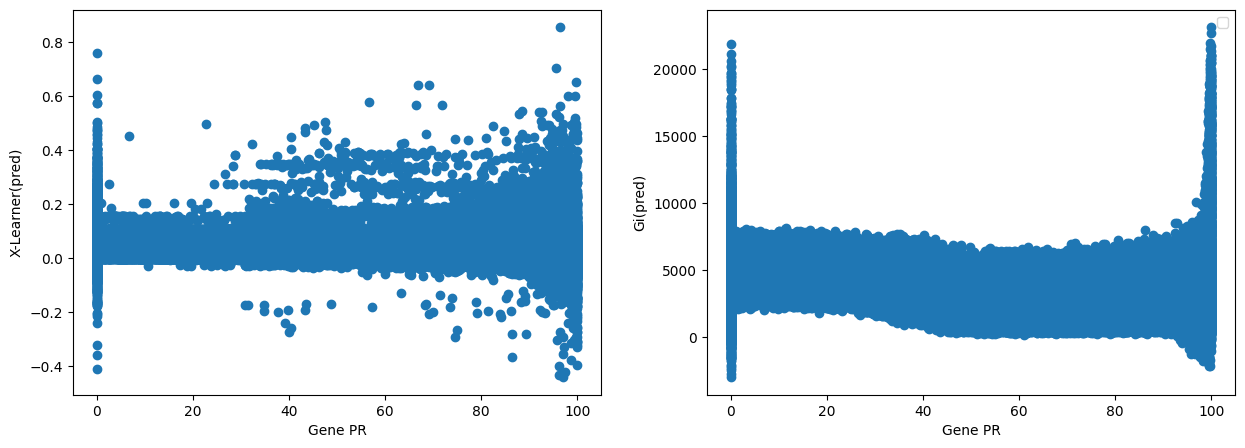

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(res.iloc[:,1], res['X_te'])
plt.xlabel('Gene PR')
plt.ylabel('X-Learner(pred)')
plt.subplot(122)
plt.scatter(res.iloc[:,1], res.iloc[:,-1])
plt.xlabel('Gene PR')
plt.ylabel('Gi(pred)')
plt.legend()

In [ ]:
res

,UNINO,換匯基因標籤,換匯發送名單,換匯金額,跨售行為,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|X,T = 0","E(V)|X,T = 1",Gi
0,19039293TA8,69.4046,0.0,0.0,0.0,0.002386,0.008154,0.005768,0.003355,177.778387,819.185319,641.406933
1,19042120PA8,66.0392,0.0,0.0,0.0,0.002045,0.009737,0.007692,0.003227,133.481863,859.944493,726.462630
2,19052324OK8,21.5505,0.0,0.0,0.0,0.001096,0.011065,0.009969,0.001252,86.408857,1299.562493,1213.153636
3,19052578MU0,0.0000,0.0,0.0,0.0,0.026656,0.015381,-0.011274,0.007023,4297.286795,3289.496450,-1007.790345
4,19079774PA8,36.2380,0.0,0.0,0.0,0.009134,0.014558,0.005424,0.009497,622.330771,1599.892850,977.562079
...,...,...,...,...,...,...,...,...,...,...,...,...
1053161,Z2229999030,96.6244,0.0,0.0,0.0,0.007352,0.002349,-0.005002,-0.000402,984.089732,341.547089,-642.542642
1053162,Z2422221010,23.6684,0.0,0.0,0.0,0.000982,0.008851,0.007869,0.001056,108.050892,1232.690112,1124.639220
1053163,Z2422273090,89.5261,0.0,0.0,0.0,0.006808,0.003296,-0.003512,0.000387,700.356789,431.574309,-268.782480
1053164,Z2794749990,70.9457,0.0,0.0,0.0,0.002062,0.009770,0.007708,0.002707,124.680001,790.974459,666.294458


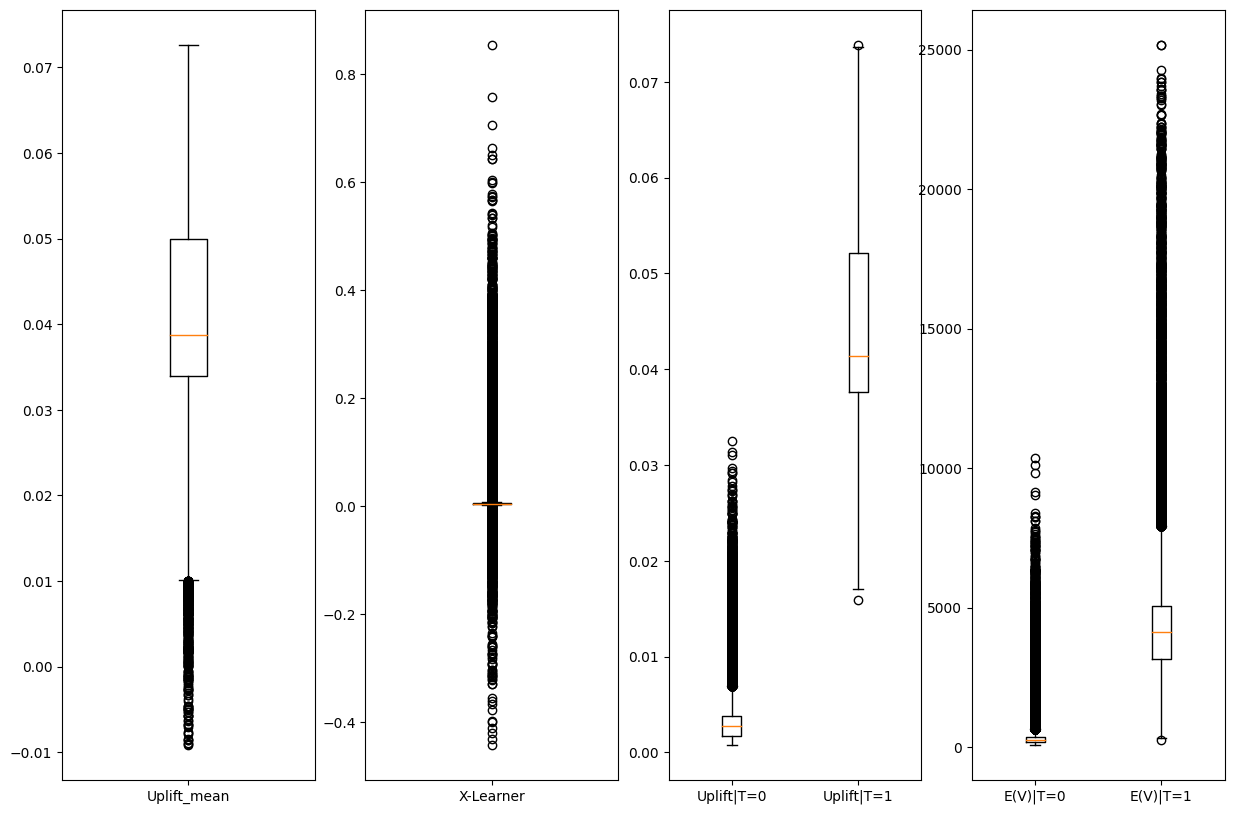

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize =(15, 10))

plt.subplot(141)
plt.boxplot(res['Uplift_mean'], labels=['Uplift_mean'])
# Creating plot
plt.subplot(142)
plt.boxplot(res['X_te'], labels=['X-Learner'])
plt.subplot(143)
plt.boxplot(res[['Uplift_mean|T = 0', 'Uplift_mean|T = 1']], labels=['Uplift|T=0', 'Uplift|T=1'])
plt.subplot(144)
plt.boxplot(res[['E(V)|X,T = 0', 'E(V)|X,T = 1']], labels=['E(V)|T=0', 'E(V)|T=1'])

# show plot
plt.show()